# SVM_MNIST_QUANTUM

In [ ]:
import numpy as np
from datasetmnist import q_mnist
from sklearn.datasets.samples_generator import make_blobs
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
from sklearn import svm
#from utils import svm_utils 
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

How it’s built:

First step is preparing the  dataset for the quantum circuit and importing it so the algorithm can be run. The steps are:

Import dataset from sklearn or the dataset can be imported through this website.

Define your variables to include training datasets, testing dataset and how it’s split.

Normalize dataset to have 0 unit variance so the pixels from the images have a very small range and can be computed efficiently.

Using IBM’s qiskit library take your current features of dataset and transform them to the number of qubits.

Set the range for SVM to -1 and +1 so classification can be done based on where a datapoint lies on the range.

Set up the training dataset.

Set up a plot to showcase visually the classification.

Next step is implementing the quantum ML algorithm. IBM has it part of their library which you can easily simulate. The steps are:

Setting up how many qubits your quantum circuit will have.

Defining your classes again and import the dataset which you manipulated above.

Dictating the algorithm and setting its parameters for how many runs it will do and depth of the circuit.

Input the new datapoints

Check for results after the algorithm is finished running.

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      7    0    0    0    0    0    0    0    0    0  ...      0      0   
1      2    0    0    0    0    0    0    0    0    0  ...      0      0   
2      1    0    0    0    0    0    0    0    0    0  ...      0      0   
3      0    0    0    0    0    0    0    0    0    0  ...      0      0   
4      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
6041    2
1677    5
4352    3
5212    3
1691    1
       ..
7422    1
2489    4
1941    7
8230    9
921     2
Name: label, Length: 3000, dtype: int64
Train: X=

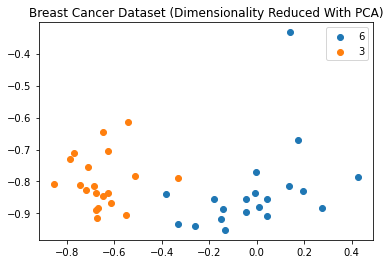

In [22]:
n = 2 # number of principal components kept
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = q_mnist(training_dataset_size, testing_dataset_size, n)

data_train, _ = split_dataset_to_data_and_labels(training_input)
data_test, _ = split_dataset_to_data_and_labels(test_input)


In [6]:
data_train[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Build circuit for feature map


In [23]:
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

feature_map = SecondOrderExpansion(feature_dimension=2, 
                                   depth=1)

The function `SecondOrderExpansion` has the arguments `feature_dimension`, which is the dimension of the input data $\vec{x}$ and at the same time also the number of qubits. `depth` is the number of repetitions of the feature map.

The Second Order Expansion refers to the number of interacting qubits.

### QSVM Algorithm

Qiskit aqua provides a pre-defined function to train the whole QSVM. Where we only have to provide the feature map, a training and a test set and Qiskit will do all the work for us.

Apart from finding the quantum Kernel the QSVM algorithm does only classical optimization. In the end there is no difference to the classical SVM, except that the Kernels are coming from a quantum distribution.


In [24]:
from qiskit.aqua.algorithms import QSVM

qsvm = QSVM(feature_map, training_input, test_input)

#### Run QSVM

Finally we will have to define where we would like to run this algorithm. For now we will run it on a local QASM Simulator. But the algorithm could also be sent to the IBMQ an be evaluated on a real quantum computer.

We will have to define the `shots`, which are the number of measurements that we will take for each qubit. And for better reproducability we also set here the random seeds `seed_simulator` and `see_transpiler`.

In [25]:
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=10598, seed_transpiler=10598)

result = qsvm.run(quantum_instance)

### Analyze output

`results` is a dictionary that contains elements like the kernel matrix, the label predictions and also the classical weights of the QSVM.

Let's have a quick look at them:

#### The kernel matrix for the training

Since the training set contains 40 elements, the kernel matrix has dimension 40x40

In [26]:
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  1.0


In [16]:
test_set = np.concatenate((test_input['3'], test_input['6']))
y_test = qsvm.predict(test_set, quantum_instance)

In [ ]:

predicted_labels = qsvm.predict(data_train[0])

predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("ground truth: {}".format(data_train[1]))
print("prediction:   {}".format(predicted_labels))